Links to study:
* https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365#:~:text=A%20simple%20approach%20could%20be,variance%20of%20the%20continuous%20variable.&text=If%20the%20variables%20have%20no,similar%20to%20the%20original%20variance.
* https://www.analyticsvidhya.com/blog/2016/01/guide-data-exploration/
* https://www.analyticsvidhya.com/blog/2016/02/bigmart-sales-solution-top-20/

The data scientists at BigMart have collected sales data for 1559 products across 10 stores in different cities for the year 2013. Now each product has certain attributes that sets it apart from other products. Same is the case with each store.
The aim is to build a predictive model to find out the sales of each product at a particular store so that it would help the decision makers at BigMart to find out the properties of any product or store, which play a key role in increasing the overall sales.

## Hypothesis generation

Hypothesis generation helps a data scientist to start looking for patterns. Usually those hypothesis are generated by sales or marketing people who know the struggles; they would be the best people to talk to. However, with a dataset like this, a simple Google search will return several possible patterns that can be found in the data. This step should be done before we start looking at data, and modified accordingly as we move along.


We can start the process by working on four levels: 
* Store Level Hypothesis
    * City Type: Stores located in downtown or urban zones should have higher sales because people tend to have higher income
    * Store size: The bigger the store, the more sales it has due to the size of the store
    * Competitors: If it's possible to see the region/neighborhood and see how many stores of the same type are out there, then logically the sales should go down due to the competition
    * Location: If a store is close to subway/bus stations/popular marketplaces, then sales should go up due to the location
* Product Level Hypothesis
    * Brand: Despite having a cheap knock off that is fairly equal, people still tend to go for brands. While I could not find a peer-reviewed research article on that topic, [1] is a good starting source. This hypothesis needs to be proper researched if data shows reversed behaviour
    * Packaging: This article [2] demonstrates that packaging is in fact matters
    * Advertising: Better advirtising of products should drive the sales up
* Customer level
    * Family vs. singles: Number of family members in the household will command the sales per customer.
    * Customer profile: This can be done based on per department. If the common audience in the neighborhood is young people working in tech, things like keyboards, monitors will be sold more, compared to let's say, diapers
* Macro level
    * The economic stability of the national currency will drive the sales up.


References:
1. https://microarts.com/insights/7-reasons-why-brands-matter-to-your-consumers/
2. https://medium.com/@contact_15268/why-packaging-matters-and-how-to-make-a-difference-8ae8207f0a25#:~:text=As%20several%20studies%20have%20shown,affects%20brand%20and%20product%20perception.&text=On%20the%20luxury%20goods%20market,%E2%80%9CGift%2Dlike%E2%80%9D%20packaging.

At this stage, we start looking for patterns. Kaggle likes to divide dataset into train and test, and usually that's not done. We will be given a dataset that can be divided further into train and test. Clients will use their own dataset to test the final models.

I will take a quick look at both sets but I will combine them into one down the road. I will assume that test set is coming from the same distribution as a train set; an assumption that I make only because this is a Kaggle dataset. 

In [1]:
import pandas as pd 
import numpy as np                     
import seaborn as sns                  
import matplotlib.pyplot as plt        
%matplotlib inline 

In [2]:
df_train = pd.read_csv ('Train.csv')
df_test = pd.read_csv('Test.csv')
print(df_train.shape)
print(df_test.shape)

(8523, 12)
(5681, 11)


As it's possible to see one of the columns that exist in the training set, doesn't exist in the test set. Because it's only 12 columns, I can print them out and compare but I would rather treat this as if I have many columns

In [3]:
df_train.columns.difference(df_test.columns)

Index(['Item_Outlet_Sales'], dtype='object')

I have `Item_Outlet_Sales` as a columns that doesn't exist in the test set. It's becoming quite obvious that this column is actually a target. In industrial application, this is not that obvious; one will need to identify target based on 1) talking to people, and them telling you that this metric (or column) is something that they use for their purposes; 2) finding correlation between variables; logically speaking, a target variable should have correlation with more than one variable. It's pretty loose to find a target variable like that, and that involves some research (reading papers, Googling, even asking professionals through LinkedIn).

In this project, I will train and evaluate my algorithms using `train` set. `test` set is used by Kaggle to rank solutions.

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


We can see that there are 5 numerical (target is numerical as well) and 7 categorical.

Target being numerical tells us that this is a regression problem, and good classification scores will be MAE, MSE, RMSE

## EDA

Exploratory Data Analysis is the first step. Understanding the properties of data, missing values (how to impute them), relationship with other variables.

This is a great dataset to learn that because:
* It's not that large; it's pretty easy to visualize 12 features and compare them to one another
* Dataset has not only numerical but also categorical variables


As I have mentioned I will be doing all my work on the `train` set. However, it's important to mention that imputing variables, dropping features will affect the dataset. Ideally, `test` set should be put through a `pipeline` to maintain the integrity of data; if we calculate the median for the training set and use that value for imputation, the same value should be used in the test set.

Kaggle kernels usually don't do that. They tend to combine datasets and do their work on that combined one; not something that can be used in production, as when the new data will be coming in, it won't be imputed automatically. As the result, in this project, I will be approaching it with the goal of putting the final model into production.

In [5]:
df = df_train.copy()

In [6]:
df['Item_Outlet_Sales'].describe()

count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

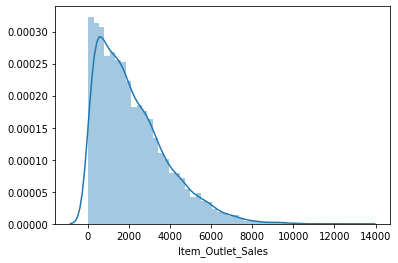

In [7]:
sns.distplot(df['Item_Outlet_Sales'])
plt.show()


Target variable is a little skewed to the left. Because this is a target variable, I don't want to look for outliers in here; as a matter of fact, I don't want to touch it at all.

Here is the thing; most posts on Medium will tell you to fix that skewness by taking the log of the feature. This is true if we deal with linear algorithms. One of the assumptions for the linear regression is to have normality for the residual errors; it's reasonable to assume that the actual response variable might not be. As the result, while it's an option to fix the skewed distribution, it's ok with leaving it like that. That's especially true for ML models like SVM, Random Forest, Neural Nets as they don't have any of the assumptions similar to linear regression.

In [8]:
categorical_features = df.select_dtypes(include=[np.object])
categorical_features.head(10)

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDA15,Low Fat,Dairy,OUT049,Medium,Tier 1,Supermarket Type1
1,DRC01,Regular,Soft Drinks,OUT018,Medium,Tier 3,Supermarket Type2
2,FDN15,Low Fat,Meat,OUT049,Medium,Tier 1,Supermarket Type1
3,FDX07,Regular,Fruits and Vegetables,OUT010,NaN,Tier 3,Grocery Store
4,NCD19,Low Fat,Household,OUT013,High,Tier 3,Supermarket Type1
5,FDP36,Regular,Baking Goods,OUT018,Medium,Tier 3,Supermarket Type2
6,FDO10,Regular,Snack Foods,OUT013,High,Tier 3,Supermarket Type1
7,FDP10,Low Fat,Snack Foods,OUT027,Medium,Tier 3,Supermarket Type3
8,FDH17,Regular,Frozen Foods,OUT045,NaN,Tier 2,Supermarket Type1
9,FDU28,Regular,Frozen Foods,OUT017,NaN,Tier 2,Supermarket Type1


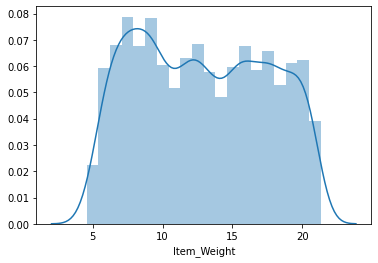

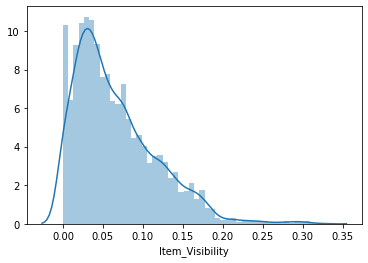

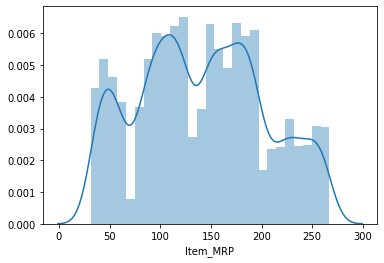

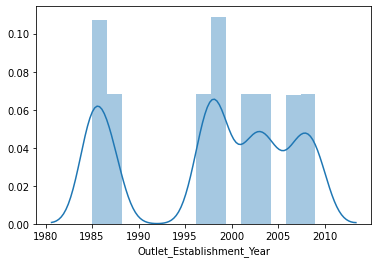

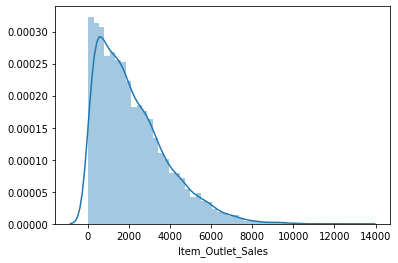

In [9]:
numerical_features = df.select_dtypes(exclude=[np.object])
for feature in numerical_features:
    plt.figure()
    sns.distplot(df[feature])
    plt.show()

It seems like `Outlet_Establishment_Year` doesn't have much of variance. 

That could be considered when we do feature selection.

Also, `Item_MRP` is Maximum Retail Price of the product. `Item_Visibility` is the % of total display area of all products in a store allocated to the particular product.

In [10]:
numerical_features.head(10)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,9.300,0.016047,249.8092,1999,3735.1380
1,5.920,0.019278,48.2692,2009,443.4228
2,17.500,0.016760,141.6180,1999,2097.2700
3,19.200,0.000000,182.0950,1998,732.3800
4,8.930,0.000000,53.8614,1987,994.7052
5,10.395,0.000000,51.4008,2009,556.6088
6,13.650,0.012741,57.6588,1987,343.5528
7,NaN,0.127470,107.7622,1985,4022.7636
8,16.200,0.016687,96.9726,2002,1076.5986
9,19.200,0.094450,187.8214,2007,4710.5350


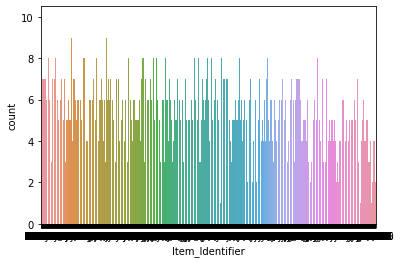

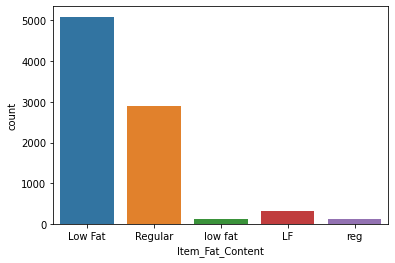

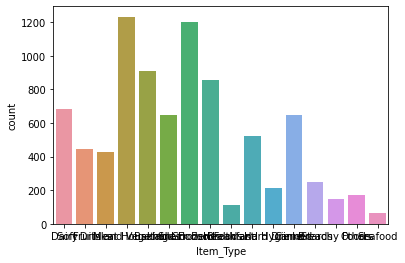

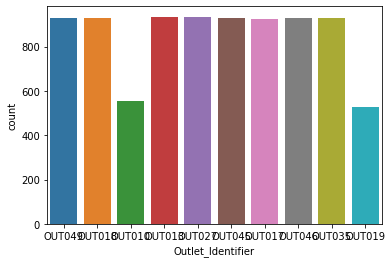

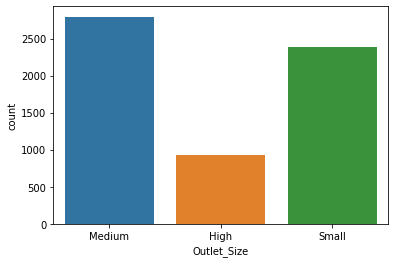

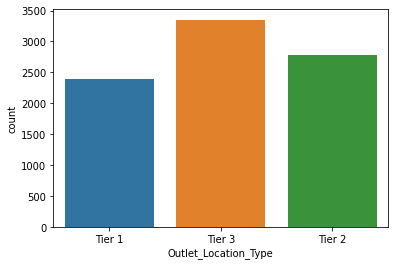

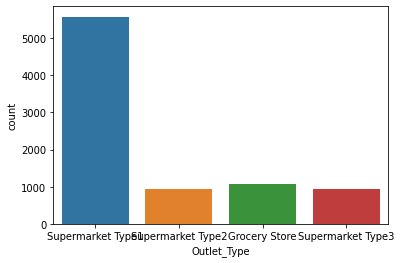

In [11]:
for feature in categorical_features:
    plt.figure()
    sns.countplot(x=feature, data=df)
    plt.show()

In `Item_Fat_Content` Low Fat, low fat and LF are all the same things. We will need to clean that data a bit

In [12]:
df['Item_Fat_Content'].replace({'reg':'Regular',
                                'low fat':'Low Fat',
                                'LF':'Low Fat'},inplace = True)

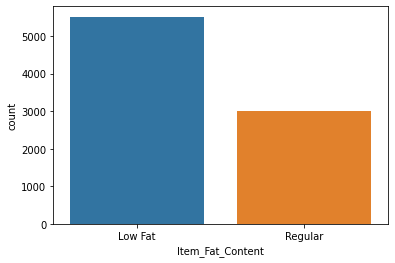

In [13]:
sns.countplot(x='Item_Fat_Content', data=df)
plt.show()

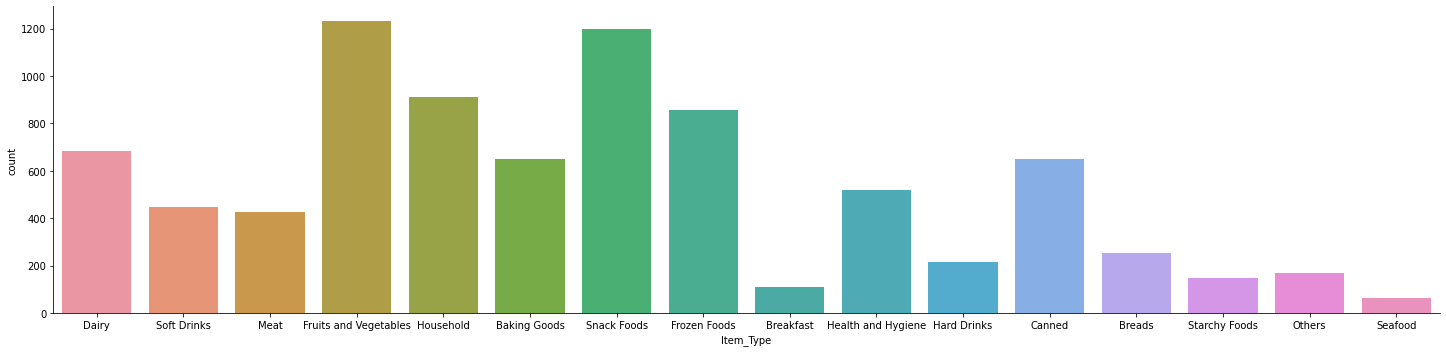

In [14]:
sns.catplot('Item_Type',kind = 'count',data = df,aspect =4)
plt.show()

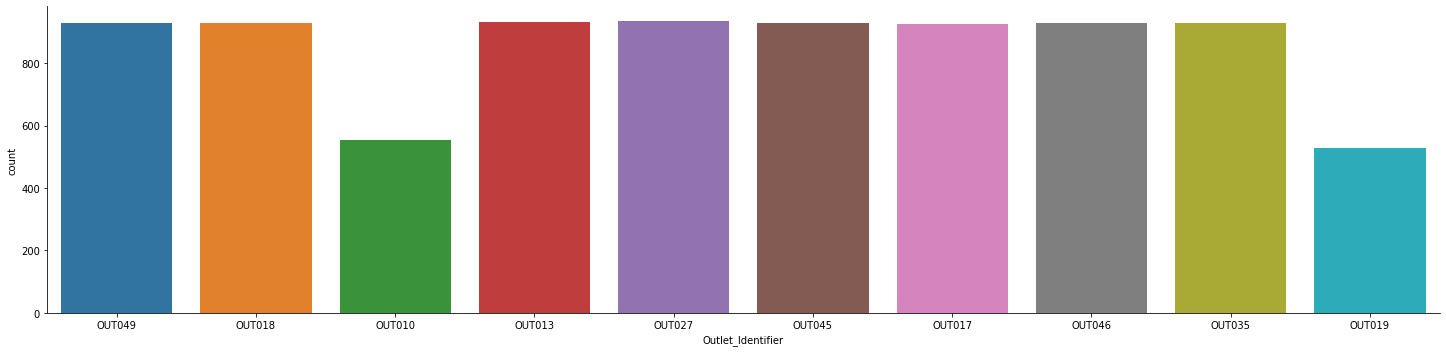

In [15]:
sns.catplot('Outlet_Identifier',kind = 'count',data = df,aspect =4)
plt.show()

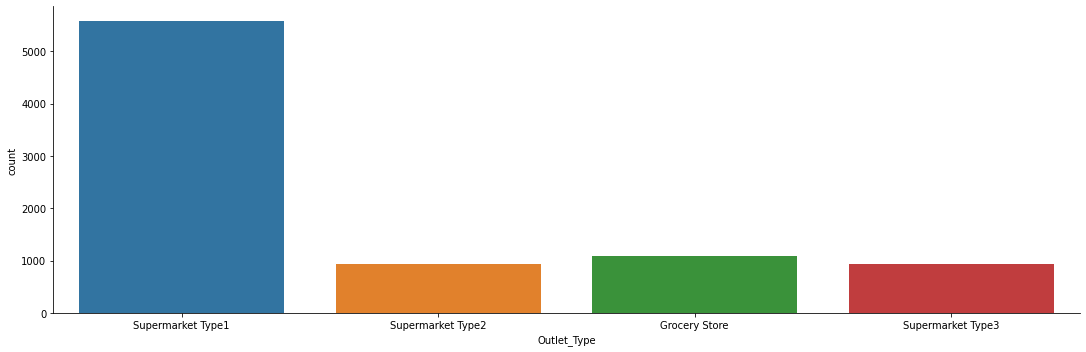

In [16]:
sns.catplot('Outlet_Type',kind = 'count',data = df,aspect =3)
plt.show()

## Target Variable vs. Numerical Variable

If we take a look at the target variable vs. numerical ones, we can maybe find some patterns in the relationship. If we do find those, we can do feature engineering.

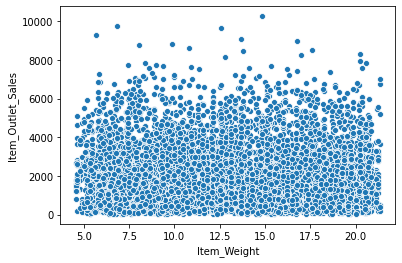

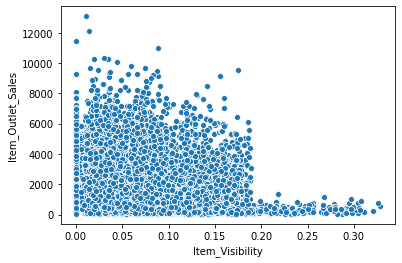

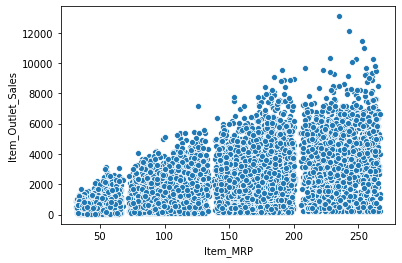

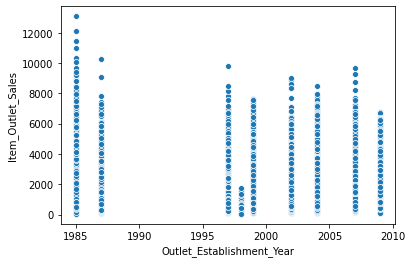

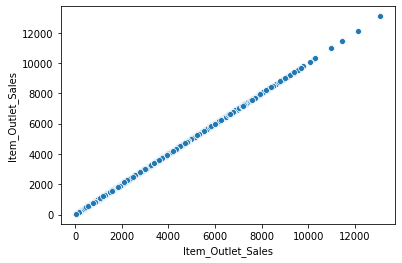

In [17]:
for feature in numerical_features:
    sns.scatterplot(x=feature,y='Item_Outlet_Sales', data=df)
    plt.show()

I will ignore the column `Item_Outlet_Sales`; it's obvious that there is a perfect correlation with the target variables.

* `Item_Weight` doesn't show any pattern. The values are all spread out
* `Item_Visibility` for some reason shows a pattern at 0. This needs to be explored more
* `Item_MRP` shows 4 independent segments. It's possible to divide data into groups just based on that scatter plot but I won't do it for now. I can use that for feature engineering
* `Outlet_Establishment_Year`: I find it weird that there are no target variable for years 1990 and 1995. Does that mean that those values are missing?
    * After a quick check, it seems like there is a gap in data from 1987-1996, and it starts again from 1998

In [18]:
df.loc[df['Outlet_Establishment_Year'] == 1990]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


In [19]:
df['Outlet_Establishment_Year'].value_counts()

1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64

## Target Variable vs. Categorical Variable

There are a few ways of plotting the relationship between numerical and categorical data. The violin plot is one of those. For each level of the categorical variable, a distribution of the values on the numeric variable is plotted. The distribution is plotted as a kernel density estimate, something like a smoothed histogram.

A box plot is another way of showing the relationship between a numeric variable and a categorical variable. Compared to the violin plot, the box plot leans more on summarization of the data, primarily just reporting a set of descriptive statistics for the numeric values on each categorical level. To describe the box plot: IQR is essentially the range from lower quantile (Q1) and upper quantile (Q3). Median is right in the middle. Whiskers (solid vertical lines from upper/lower quantile to upper/lower extreme) indicate the range from the first or third quantiles to the minimum or maximum valie in distribution. Maximum range is set up to 1.5 * IQR.

The inner boxes and lines in the violin plot match up with the boxes and whiskers in the box plot

<Figure size 432x288 with 0 Axes>

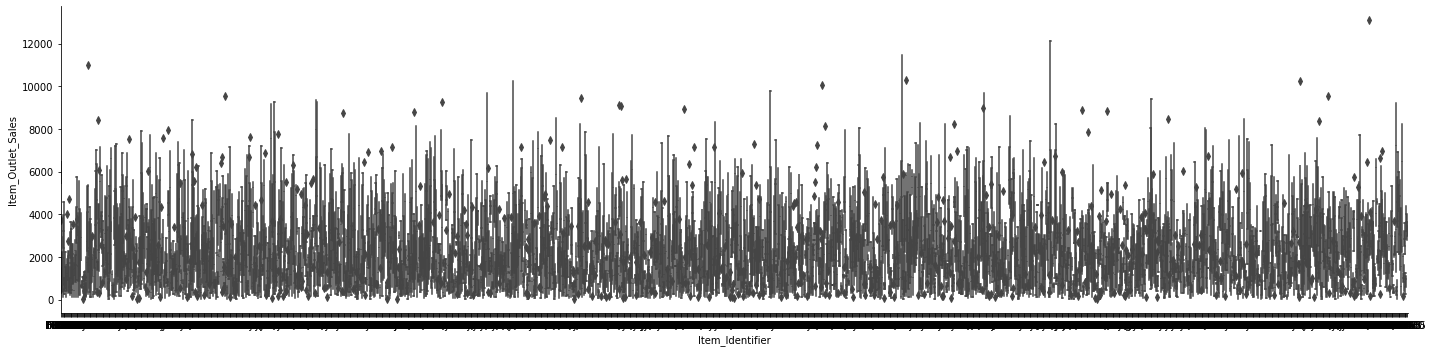

<Figure size 432x288 with 0 Axes>

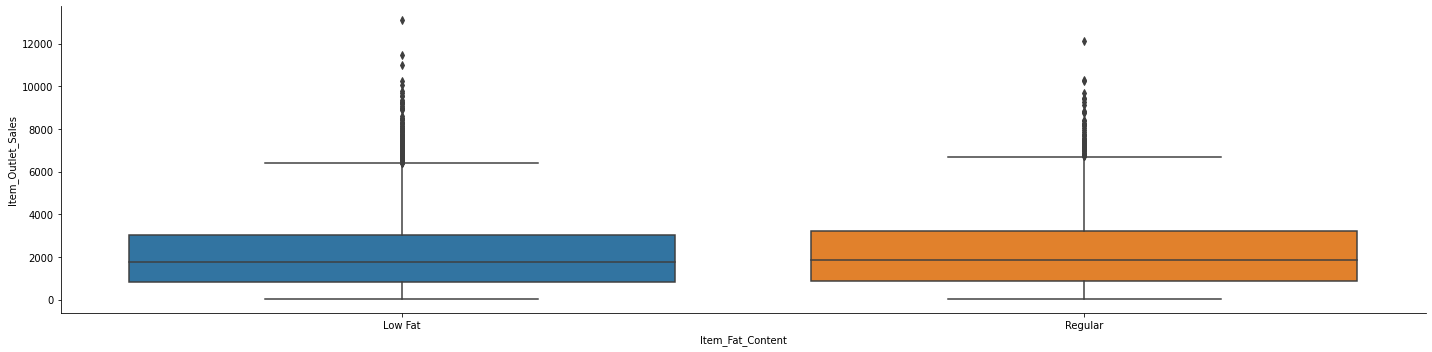

<Figure size 432x288 with 0 Axes>

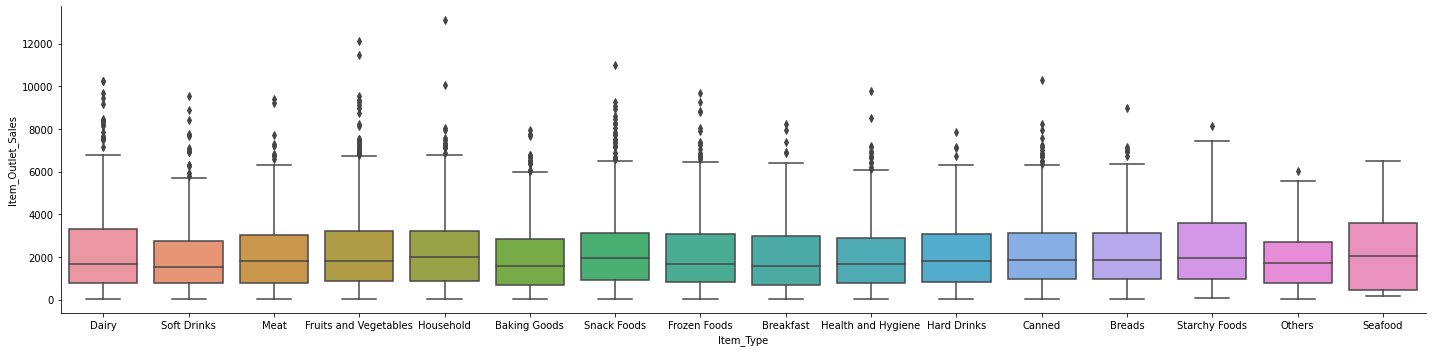

<Figure size 432x288 with 0 Axes>

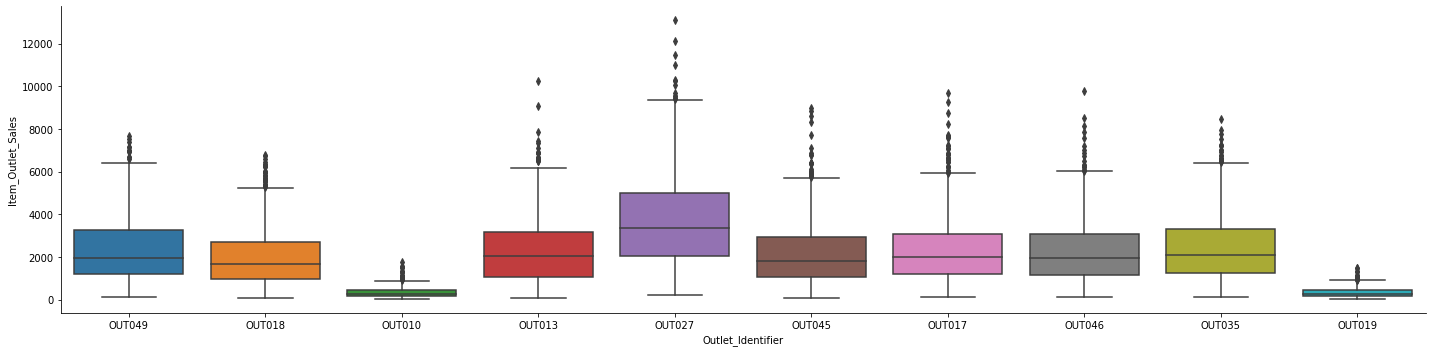

<Figure size 432x288 with 0 Axes>

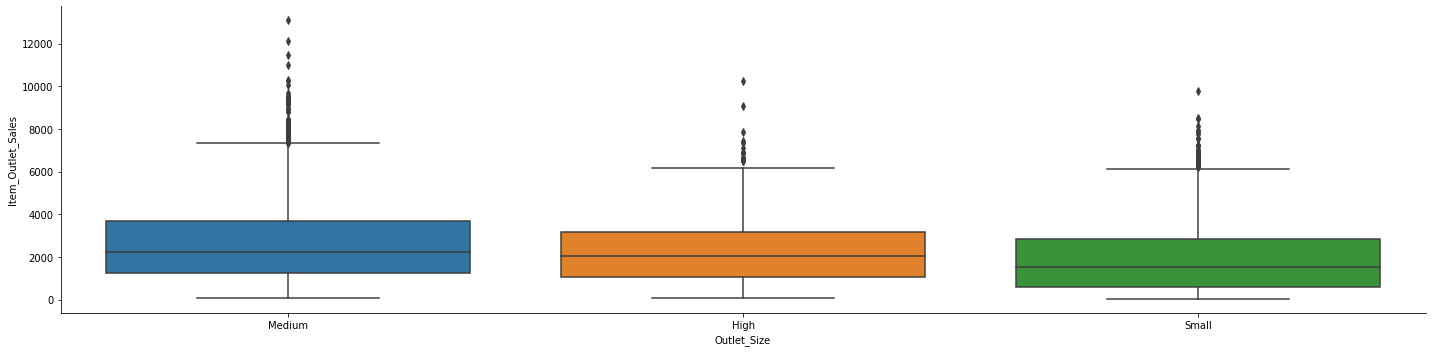

<Figure size 432x288 with 0 Axes>

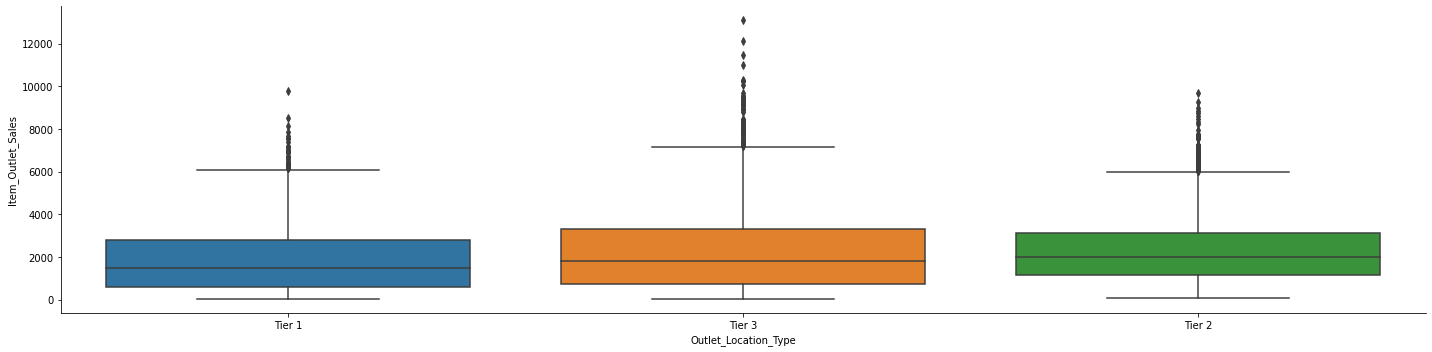

<Figure size 432x288 with 0 Axes>

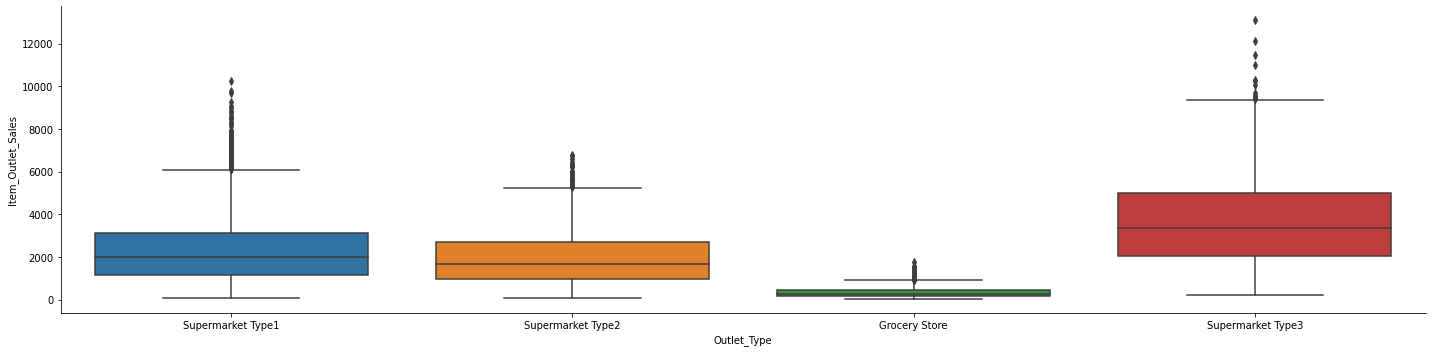

In [20]:
for feat in categorical_features:
    plt.figure()
    sns.catplot(x=feat, y='Item_Outlet_Sales',data=df, kind='box', aspect=4)  
    plt.show()
    
#the only reason I keep using sns.catplot is due to aspect (otherwise, I would use sns.boxplot)    

Usually, boxplots are super helpful to identify outliers. In this case, I am not too concerned with the outliers; maybe, in further analysis, I will remove them to improve the prediction. However, not always the points outside of the maximum range mean that those points are outliers.

General Conclusion:
* Item_Type doesn't really tells us anything. Sales of the product in the particular store (`Item_Outlet_Sales`) don't correlate that much with what they are selling; it makes sense. Usually, stores will sell more or less the same things. Yes, Dairy might have been sold a little more (outliers) but in general, it doesn't tell us much
* `Item_Fat_Content` is also the same; it doesn't really tell us much.

I was actually more curious to explore columns with the name `Outlet_` in them. Logically, they should correlate more with the sales of a product in the particular store:
* `Outlet_Size` shows that. The larger the store is, the more they can sell.
* `Outlet_Location_Type` also shows that Tier 3 can sell more. I don't know what Tier 3 really means, and I cannot find it in the dataset
* `Outlet_Type`: Grocery store seem to be selling less. It might not be 100% accurate; grocery stores probably focus on selling groceries only while Supermarkets sell everything. I will explore this option just for the sake of it.

## Missing Data Treatment

While there are algorithms that can work with missing data (XGBoost), I will prefer to impute them, so I can use more algorithms, and choose the best one.

There are couple of different ways to address this issue:
* Deletion of rows/columns: If most of the NA values are focused in a column/columns, and that column doesn't have a strong predictive power, then it's best to drop that column. Another option is to drop rows, if doing so will not drop a significant portion of samples
* Mean/Median/Mode imputation: na values can be replaced with a statistical value (mean or median for numerical or mode for categorical). Another simple option is to use something like forward fill; note, that this option is useful mostly for independent variables (be very careful with time series data as time series are not independent)
* kNN: Will impute based on the nearest neigbor. There is a problem with this approach; kNN stores data in memory and as the result, anything that is larger than a toy dataset will kill the kernel.
* MICE: Multiple Imputations by Chained Equations

In this case, I would rather drop Item_Weight and Outlet_Size. However, I can imagine things might look different, and as the result when I will write a class, I will account for the fact that if NA percentage in individual columns will be below a certain threshold, then I will use MICE to impute those values. Previously, MICE could have imported from `fancyimpute` but it seems like sklearn has adopted it (https://machinelearningmastery.com/iterative-imputation-for-missing-values-in-machine-learning/).

In [21]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [22]:
#I will have to distinguish between object and numerical
# explicitly require this experimental feature

#When I will be writing a class for this project, this needs to be done internally.
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer


imputer_num = IterativeImputer()
# fit on the dataset
df_numerical = pd.DataFrame(imputer_num.fit_transform(numerical_features), 
                            columns=numerical_features.columns)

#With categorical, it will be slightly different
categorical_features = categorical_features.fillna(categorical_features.mode().iloc[0])

df_imputed = pd.concat([df_numerical,categorical_features], axis=1)
df_imputed.shape

(8523, 12)

In [23]:
df_imputed = df_imputed.reindex(df.columns,axis=1)
df_imputed.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

That 0 for `Item_Visibility` didn't make a lot of sense.

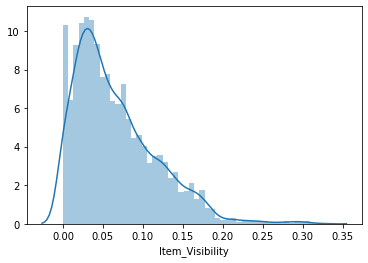

In [24]:
plt.figure()
sns.distplot(df_imputed['Item_Visibility'])
plt.show()

In [25]:
df_imputed['Item_Visibility'] = df_imputed['Item_Visibility'].replace(0, df_imputed['Item_Visibility'].mean())

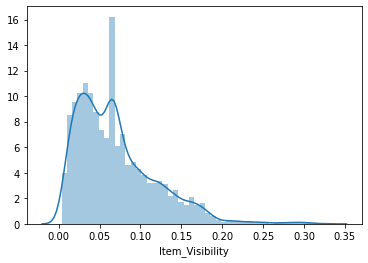

In [26]:
plt.figure()
sns.distplot(df_imputed['Item_Visibility'])
plt.show()

## Feature Engineering

To make predictions a little easier, there are some samples in the features that can be wrapped under the same common name.

When it comes to categorical, I just don't want to encode items that can mean exactly the same thing but will be encoded differently. 

Example: Every thing from `Item_Identifier` can be coded as `Food`, `Drink`, `Non-consumable`

In [27]:
df_imputed.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300000,Low Fat,0.016047,Dairy,249.8092,OUT049,1999.0,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920000,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009.0,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500000,Low Fat,0.016760,Meat,141.6180,OUT049,1999.0,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200000,Regular,0.066132,Fruits and Vegetables,182.0950,OUT010,1998.0,Medium,Tier 3,Grocery Store,732.3800
4,NCD19,8.930000,Low Fat,0.066132,Household,53.8614,OUT013,1987.0,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395000,Regular,0.066132,Baking Goods,51.4008,OUT018,2009.0,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650000,Regular,0.012741,Snack Foods,57.6588,OUT013,1987.0,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,12.821823,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985.0,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200000,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002.0,Medium,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200000,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007.0,Medium,Tier 2,Supermarket Type1,4710.5350


In [28]:
for counter, value in enumerate(df_imputed['Item_Identifier']):
    if 'FD' in value:
        df_imputed['Item_Identifier'][counter] = df_imputed['Item_Identifier'][counter].replace(value, 'FD')
    elif 'DR' in value:
        df_imputed['Item_Identifier'][counter] = df_imputed['Item_Identifier'][counter].replace(value, 'DR')        
    elif 'NC' in value:
        df_imputed['Item_Identifier'][counter] = df_imputed['Item_Identifier'][counter].replace(value, 'NC')


/anaconda3/envs/dsa/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/dsa/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/anaconda3/envs/dsa/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


As we have replaced `Item_Identifier` with `FD`,`DR` and `NC`, we actually need to make sure that `Item_Fat_Content` reflects that; non eatable food cannot have any fat

In [29]:
df_imputed['Item_Fat_Content'].replace({'reg':'Regular',
                                        'low fat':'Low Fat',
                                        'LF':'Low Fat'},inplace = True)
df_imputed['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [30]:
df_imputed[df_imputed['Item_Identifier'].str.contains('NC')]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
4,NC,8.930000,Low Fat,0.066132,Household,53.8614,OUT013,1987.0,High,Tier 3,Supermarket Type1,994.7052
16,NC,11.800000,Low Fat,0.008596,Health and Hygiene,115.3492,OUT018,2009.0,Medium,Tier 3,Supermarket Type2,1621.8888
22,NC,14.600000,Low Fat,0.025698,Household,196.5084,OUT035,2004.0,Small,Tier 2,Supermarket Type1,1587.2672
25,NC,13.000000,Low Fat,0.099887,Household,45.9060,OUT017,2007.0,Medium,Tier 2,Supermarket Type1,838.9080
31,NC,18.600000,Low Fat,0.080829,Health and Hygiene,96.4436,OUT018,2009.0,Medium,Tier 3,Supermarket Type2,2741.7644
...,...,...,...,...,...,...,...,...,...,...,...,...
8500,NC,20.350000,Low Fat,0.066132,Household,125.1678,OUT017,2007.0,Medium,Tier 2,Supermarket Type1,1907.5170
8502,NC,8.420000,Low Fat,0.070712,Household,216.4192,OUT045,2002.0,Medium,Tier 2,Supermarket Type1,3020.0688
8504,NC,12.828367,Low Fat,0.124111,Household,111.7544,OUT027,1985.0,Medium,Tier 3,Supermarket Type3,4138.6128
8516,NC,18.600000,Low Fat,0.118661,Others,58.7588,OUT018,2009.0,Medium,Tier 3,Supermarket Type2,858.8820


In [31]:
df_imputed['Item_Fat_Content'][df_imputed['Item_Identifier'].str.contains('NC')]='Non Consumable'

/anaconda3/envs/dsa/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
df_imputed[df_imputed['Item_Identifier'].str.contains('NC')]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
4,NC,8.930000,Non Consumable,0.066132,Household,53.8614,OUT013,1987.0,High,Tier 3,Supermarket Type1,994.7052
16,NC,11.800000,Non Consumable,0.008596,Health and Hygiene,115.3492,OUT018,2009.0,Medium,Tier 3,Supermarket Type2,1621.8888
22,NC,14.600000,Non Consumable,0.025698,Household,196.5084,OUT035,2004.0,Small,Tier 2,Supermarket Type1,1587.2672
25,NC,13.000000,Non Consumable,0.099887,Household,45.9060,OUT017,2007.0,Medium,Tier 2,Supermarket Type1,838.9080
31,NC,18.600000,Non Consumable,0.080829,Health and Hygiene,96.4436,OUT018,2009.0,Medium,Tier 3,Supermarket Type2,2741.7644
...,...,...,...,...,...,...,...,...,...,...,...,...
8500,NC,20.350000,Non Consumable,0.066132,Household,125.1678,OUT017,2007.0,Medium,Tier 2,Supermarket Type1,1907.5170
8502,NC,8.420000,Non Consumable,0.070712,Household,216.4192,OUT045,2002.0,Medium,Tier 2,Supermarket Type1,3020.0688
8504,NC,12.828367,Non Consumable,0.124111,Household,111.7544,OUT027,1985.0,Medium,Tier 3,Supermarket Type3,4138.6128
8516,NC,18.600000,Non Consumable,0.118661,Others,58.7588,OUT018,2009.0,Medium,Tier 3,Supermarket Type2,858.8820


In [33]:
df_imputed.head(20)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FD,9.300000,Low Fat,0.016047,Dairy,249.8092,OUT049,1999.0,Medium,Tier 1,Supermarket Type1,3735.1380
1,DR,5.920000,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009.0,Medium,Tier 3,Supermarket Type2,443.4228
2,FD,17.500000,Low Fat,0.016760,Meat,141.6180,OUT049,1999.0,Medium,Tier 1,Supermarket Type1,2097.2700
3,FD,19.200000,Regular,0.066132,Fruits and Vegetables,182.0950,OUT010,1998.0,Medium,Tier 3,Grocery Store,732.3800
4,NC,8.930000,Non Consumable,0.066132,Household,53.8614,OUT013,1987.0,High,Tier 3,Supermarket Type1,994.7052
5,FD,10.395000,Regular,0.066132,Baking Goods,51.4008,OUT018,2009.0,Medium,Tier 3,Supermarket Type2,556.6088
6,FD,13.650000,Regular,0.012741,Snack Foods,57.6588,OUT013,1987.0,High,Tier 3,Supermarket Type1,343.5528
7,FD,12.821823,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985.0,Medium,Tier 3,Supermarket Type3,4022.7636
8,FD,16.200000,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002.0,Medium,Tier 2,Supermarket Type1,1076.5986
9,FD,19.200000,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007.0,Medium,Tier 2,Supermarket Type1,4710.5350


Earlier in the Item_MRP vs Item_Outlet_Sales plot, we saw Item_MRP was spread across in 4 chunks. Now let’s assign a label to each of these chunks and use this label as a new variable.

```python
def clusters(x):
    if x<69:
        return '1st'
    elif x in range(69,136):
        return '2nd'
    elif x in range(136,203):
        return '3rd'
    else:
        return '4th'
train['Item_MRP_Clusters'] = train['Item_MRP'].astype('int').apply(clusters)
train.head()
```

## Encoding Categorical Variables

Choosing between `LabelEncoder` and `OneHotEncoder` one must know the primary difference between them:
* Label Encoding means that we convert each string (category) to a number in the range from 0 and `n_classes - 1`
* One Hot Encoding means that each category of a categorical variable is encoded via one-hot encoding scheme, which results in the binary column for each category and returns a sparse matrix

What's more important is to know the cons of each algorithm:
* The problem with Label Encoding is that a number corresponding to a feature will be in some sort of order; the model might derive a correlation between the order of the encoded variable and some numerical column (China might be encoded as 1, and France as 2; based on that encoding, a model might find a correlation that population will grow with the respect to number, and France has a higher population density compared to China)
* The problem with OHE is that the feature space will blow up quickly and curse of dimensionality becomes a real problem. That can be addressed by doing OHE, followed by PCA for dimensionality reduction (cardinality will be too large for the collected sample size)

Before we proceed to actual fitting and transforming, there is another option, known as `OrdinalEncoder`. It has the same functionality as `LabelEncoder`, except  `OrdinalEncoder` can take a shape of `(n_samples, n_features)`, unlike `LabelEncoder` that will take only one feature; a barrier that can be bypassed via `for` loop

Another thing to mention: CatBoost and LightGBM can handle categorical features, XGBoost cannot.

In [34]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder()
df_imputed = pd.DataFrame(oe.fit_transform(df_imputed), columns=df.columns)

In [145]:
df_imputed.shape

(8523, 12)

In [148]:
list(df_imputed)

['Item_Identifier',
 'Item_Weight',
 'Item_Fat_Content',
 'Item_Visibility',
 'Item_Type',
 'Item_MRP',
 'Outlet_Identifier',
 'Outlet_Establishment_Year',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type',
 'Item_Outlet_Sales']

## Correlation between variables

What is correlation and why is it useful? Well, correlation can help in predicting one attribute from another (useful for imputing missing values)

If we observe some features to be highly correlated, multicollinearity becomes an issue; it is the best described as the case where one predictor can be linearly predicted from the other using a substantial degree of accuracy. The main impact of collinearity is loss of statistical power to detect effects or precisely estimate individual predictors.

High correlation among predictor variables can be dealed also with a penalized likelihood function (Ridge Regression, Lasso). Also, decision trees based algorithms are immune to multicollinearity; when they decide to split, the tree will choose only one of the perfectly correlated features. 

To tackle that problem, PCA can be used. Another option is removing one of the correlated variables.

I would say based on some research that choosing a threshold of 0.9 is a safe choice to indicate strongly correlated variables

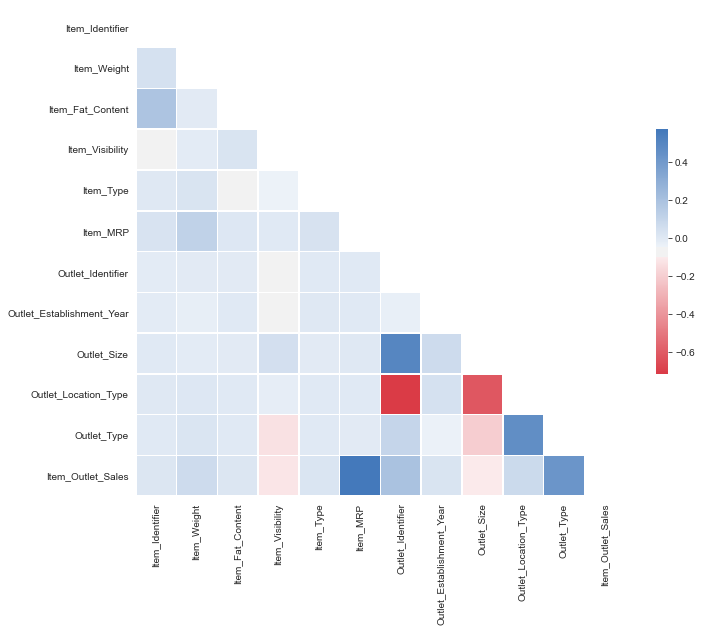

In [36]:
# Compute correlations
corr = df_imputed.corr()

# Exclude duplicate correlations by masking uper right values
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set background color / chart style
sns.set_style(style = 'white')

# Set up  matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Add diverging colormap
cmap = sns.diverging_palette(10, 250, as_cmap=True)

# Draw correlation plot
sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

## Model Building

There are quite a number of models that can be used.

I would like to start with a BaseLine model and get the base line score.

The following metrics can be used to evaluate the performance in regression algorithm:
* R-squared - between 0 and 1 and is a good measure to determine how well the model fits the dependent variables; in other words, how well the selected independent variables explain the variability in the dependent variables. However, it does not take into consideration the overfitting problem. That is why Adjusted R Square is introduced because it will penalise additional independent variables added to the model and adjust the metric to prevent overfitting issue. The bottom line is that with Adjusted R-squared, the marginal improvement that might arise from adding another term in the model is considered; R-squared will just increase even though the model is not actually improving.
* MAE: MSE gives larger penalisation to big prediction error by square it while MAE treats all errors the same. MAE is a better choice when there might be some untreated outliers
* MSE/RMSE: RMSE can reconstruct error distribution (Chai and Draxler (2014)). It's also easier to differentiate, making it a good choice when used in conjuction with gradient descent.

However, there is not much point of using only one metric; it's preferable to use multiple metrics and compare results all together to get better insight

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

X = df_imputed.iloc[:,:-1]
y = df_imputed['Item_Outlet_Sales']

#Create a function for mse, mae report

def metrics_report(y_test, y_pred):
    print ('MAE: ', mae(y_test, y_pred))
    print ('RMSE: ', mse(y_test, y_pred, squared=False))

In [38]:
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=1-train_ratio, 
                                                    random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                test_size=test_ratio/(test_ratio + validation_ratio), 
                                                random_state=42) 


In [39]:
print(X_train.shape,X_val.shape,X_test.shape)

(5966, 11) (1278, 11) (1279, 11)


In [40]:
from sklearn.dummy import DummyRegressor

model_dummy = DummyRegressor()
model_dummy.fit(X_train,y_train)
y_pred=model_dummy.predict(X_test)
metrics_report (y_test, y_pred)

MAE:  786.0243759463648
RMSE:  919.856548088125


In [41]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05)
model_xgb.fit(X_train,y_train)
y_pred=model_xgb.predict(X_test)
metrics_report (y_test, y_pred)

MAE:  425.33976835902547
RMSE:  564.4375742539955


In [42]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor()
model_rf.fit(X_train,y_train)
y_pred=model_rf.predict(X_test)
metrics_report (y_test, y_pred)

MAE:  401.39700547302584
RMSE:  544.0298148429703


In [43]:
from sklearn.linear_model import Lasso
model_ls = Lasso(alpha = 0.01)
model_ls.fit(X_train,y_train)
y_pred=model_ls.predict(X_test)
metrics_report (y_test, y_pred)

MAE:  487.100745623153
RMSE:  611.3640507856977


In [44]:
df_pred = pd.DataFrame()
df_pred['prediction'] = y_pred
df_pred['true'] = y_test.values

In [45]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


def best_model_selection (X, y, models, param_grid):
    train_ratio = 0.70
    validation_ratio = 0.15
    test_ratio = 0.15

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=1-train_ratio, 
                                                        random_state=42)

    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                    test_size=test_ratio/(test_ratio + validation_ratio), 
                                                    random_state=42) 
    
    models_with_performance = dict()
    mae_score = []
    mse_score = []
    
    for i in range(len(models)):
        model = models[i]
        random_cv = RandomizedSearchCV(estimator=model,
                                       param_distributions = param_grid[i], 
                                       cv = 5, 
                                       verbose=10, 
                                       random_state=42, 
                                       n_jobs = -1)
        random_cv.fit(X_train, y_train)
        y_pred=random_cv.predict(X_test)
        mae_score = mae(y_test, y_pred)
        #rmse_score = mse(y_test, y_pred, squared=False)
        #models_with_performance[model] = [mae_score,rmse_score]
        models_with_performance[model] = mae_score
    
    best_model = max(models_with_performance, key=models_with_performance.get)
    best_result = models_with_performance[best_model]
    return best_model, best_result
    
    
    
model_rf = RandomForestRegressor()
random_grid_rf = {'n_estimators': [int(x) for x in np.linspace(start = 0, stop = 100, num = 50)],
                   'max_features': ['auto', 'sqrt'],
                   'max_depth': [int(x) for x in np.linspace(0, 50, num = 10)],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4],
                   'bootstrap': [True, False]}

model_xgb = XGBRegressor()
random_grid_xgboost = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                       'min_child_weight': np.arange(0.0001, 0.5, 0.001),
                       'gamma': np.arange(0.0,40.0,0.005),
                       'learning_rate': np.arange(0.0005,0.3,0.0005),
                       'subsample': np.arange(0.01,1.0,0.01),
                       'colsample_bylevel': np.round(np.arange(0.1,1.0,0.01)),
                       'colsample_bytree': np.arange(0.1,1.0,0.01)}
models = list()
models.append(model_rf)
models.append(model_xgb)

params = dict()
params[0] = random_grid_rf
params[1] = random_grid_xgboost


print(best_model_selection (X, y, models, params))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.5s finished


(XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), 409.61151628591193)


In [146]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from xgboost import XGBRegressor

class BigMartNameCleaning(BaseEstimator, TransformerMixin):    
    def __init__ (self):
        super().__init__()
    
    def fit(self, X, y=None, **kwargs):
        return self
    
    
    def transform(self, X, y=None, **kwargs):
        #Do Transformation Here
        if X is None:
            raise ValueError('Input the data')
        X = X.copy()   
        X = self.predict(X)  
        return X
    
    def predict(self, X, y=None, **kwargs):
        if X is None:
            raise ValueError('Input the data')
        X = X.copy()
        
        for value in X['Item_Identifier']:    
            if 'FD' in value:
                X['Item_Identifier'] = X['Item_Identifier'].replace(value, 'FD')
            elif 'DR' in value:
                X['Item_Identifier'] = X['Item_Identifier'].replace(value, 'DR')        
            elif 'NC' in value:
                X['Item_Identifier'] = X['Item_Identifier'].replace(value, 'NC')

        X['Item_Fat_Content'].replace({'reg':'Regular',
                                       'low fat':'Low Fat',
                                       'LF':'Low Fat'},
                                      inplace = True)
        X['Item_Fat_Content'][X['Item_Identifier'].str.contains('NC')]='Non Consumable'
        return X
        
class BigMartFeatureEncoding(BaseEstimator, TransformerMixin):    
    def __init__ (self):
        super().__init__()

    def fit(self, X, y=None, **kwargs):  
        if X is None:
            raise ValueError('Input the data')
        
        self.cat_list = list(
            X.select_dtypes(include=['category', 'object', 'bool']).columns)
            
        for col in self.cat_list:
            X[col] = X.astype('object')
            
        self.X_encoding = X.select_dtypes(include=[np.object])   
        self.X_rest = X.select_dtypes(exclude=[np.object])
        
        self.oe = OrdinalEncoder()
        self.oe.fit(self.X_encoding)
        
        return self
    
    
    def transform(self,X,y=None,**kwargs):
        #Do Transformation Here
        if X is None:
            raise ValueError('Input the data')
        X = X.copy()   
        X = self.predict(X)  
        return X
    
    
    def predict(self, X, y=None, **kwargs):
        #Include all other columns
        self.cat_list = list(
                    X.select_dtypes(include=['category', 'object', 'bool']).columns)
            
        for col in self.cat_list:
            X[col] = X.astype('object')
            
        self.X_encoding = X.select_dtypes(include=[np.object])   
        self.X_rest = X.select_dtypes(exclude=[np.object])
        
        self.X_encoded = pd.DataFrame(self.oe.transform(self.X_encoding), 
                                      columns=self.X_encoding.columns)
        
        self.X_encoded.reset_index(drop=True,inplace=True)
        self.X_rest.reset_index(drop=True,inplace=True)
        
        X_out = pd.concat([self.X_encoded,self.X_rest], axis=1)
        X = X_out.reindex(X.columns,axis=1)
        return X
    

class BigMartFeatureImputation(BaseEstimator, TransformerMixin):
    def __init__ (self):
        super().__init__()
        
    def fit (self, X, y=None, **kwargs):
        #Only numerical here
        print ('fit ()')
        if X is None:
            raise ValueError('Input the data')
        
        self.X_numerical = X.select_dtypes(include='number')
        
        
        self.imputer_num = IterativeImputer()
        self.imputer_num.fit(self.X_numerical)
        
        return self
    
    def predict (self, X, y=None, **kwargs):
        X = X.copy()
        print ('transform()')
        #transform here
        
        self.cat_list = list(
            X.select_dtypes(include=['category', 'object', 'bool']).columns)
            
        for col in self.cat_list:
            X[col] = X.astype('object')
            
        self.X_categorical = X.select_dtypes(include=[np.object])   
        self.X_numerical = X.select_dtypes(include=['number'])
        
        self.X_numerical_encoded = pd.DataFrame(self.imputer_num.transform(self.X_numerical), 
                                      columns=self.X_numerical.columns)
        
    
        self.X_categorical = self.X_categorical.fillna('Missing')

        self.X_numerical_encoded.reset_index(drop=True,inplace=True)
        self.X_categorical.reset_index(drop=True,inplace=True)
        
        X_out = pd.concat([self.X_numerical_encoded,self.X_categorical], axis=1)
        X = X_out.reindex(X.columns,axis=1)
        print (X.shape)

        return X
    
    def transform(self,X,y=None,**kwargs):
        #Do Transformation Here
        if X is None:
            raise ValueError('Input the data')
        X = X.copy()   
        X = self.predict(X)  
        return X      
        
    
    
data_folder = '~/Desktop/Studying/ML'
training_set = os.path.join(data_folder, 'Train.csv')
data=pd.read_csv(training_set)

X = data.iloc[:,:-1]
y = data['Item_Outlet_Sales']
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=1-train_ratio, 
                                                    random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                test_size=test_ratio/(test_ratio + validation_ratio), 
                                                random_state=42) 

In [147]:
'''
fit calls fit and tranform
predict calls transform
'''

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.linear_model import Lasso

pipe = Pipeline(steps=[('cleaning_step', BigMartNameCleaning()),
                       ('imputation_step', BigMartFeatureImputation()),
                       ('encoding_step', BigMartFeatureEncoding()),
                       ('model', Lasso(alpha = 0.01))
                      ])

print ('fitting step')
pipe.fit(X_train, y_train)
print ('predicting step')
y_pred = pipe.predict(X_test)
metrics_report (y_test, y_pred)



fitting step


/anaconda3/envs/dsa/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


fit ()
transform()
(5966, 11)
predicting step
transform()
(1279, 11)
MAE:  1023.4319643401516
RMSE:  1376.0885954621629


/anaconda3/envs/dsa/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1279
1279


In [47]:
trans = BigMartNameCleaning()
trans.fit(X_train, y_train)

X_train_conv = trans.fit_transform(X_train)
print ('Train', X_train_conv['Item_Fat_Content'].value_counts())
print ('\n')
print ('Train', X_train_conv['Item_Identifier'].value_counts())
print ('\n')

X_test_conv = trans.predict(X_test)
print ('Test', X_test_conv['Item_Fat_Content'].value_counts())
print ('\n')
print ('Test', X_test_conv['Item_Identifier'].value_counts())

encoder = BigMartNameEncoding()
encoder.fit(X_train_conv)
encoded_train = encoder.fit_transform (X_train_conv)
encoded_test = encoder.predict(X_test_conv)

/anaconda3/envs/dsa/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train Low Fat           2723
Regular           2106
Non Consumable    1137
Name: Item_Fat_Content, dtype: int64


Train FD    4269
NC    1137
DR     560
Name: Item_Identifier, dtype: int64


Test Low Fat           573
Regular           462
Non Consumable    244
Name: Item_Fat_Content, dtype: int64


Test FD    923
NC    244
DR    112
Name: Item_Identifier, dtype: int64
fit is called


In [48]:
print(X_test_conv.shape)
print(encoded_test.shape)

(1279, 9)
(2359, 9)


In [49]:
X_train_conv.shape

(5966, 9)

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import numpy as np

pipe = Pipeline(steps=[('experimental_step', ExperimentalTransformer()),
                      ('linear_model', LinearRegression())
                      ])

X_rest = X.select_dtypes(exclude=[np.object])
print('\n Step of fit the pipeline')
pipe.fit(X_rest, y)

print ('\n Step of predict the pipeline')
pipe.predict(X_rest)


 init() is called

 Step of fit the pipeline

 fit() is called

 transform() is called

 Step of predict the pipeline

 transform() is called


array([4078.87868503,  803.22974774, 2392.64994645, ..., 1369.91831362,
       1104.78959075, 1265.5613847 ])

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import numpy as np

pipe = Pipeline(steps=[('experimental_step', ExperimentalTransformer()),
                      ('linear_model', LinearRegression())
                      ])

NameError: name 'ExperimentalTransformer' is not defined

In [63]:
class ExperimentalTransformer(BaseEstimator, TransformerMixin):    
    def __init__ (self):
        print ('\n init() is called')
        
    def fit (self, X, y=None):
        print ('\n fit() is called')
        return self
    
    def transform (self, X, y=None):
        print ('\n transform() is called')
        X = X.copy()
        return X


Going back to skewness. I want to compare how well the model does by removing the skewness.

In our case scenario, `Item_Visibility` is skewed

https://medium.com/@juniormiranda_23768/ensemble-methods-tuning-a-xgboost-model-with-scikit-learn-54ff669f988a

https://stackoverflow.com/questions/48507651/multiple-classification-models-in-a-scikit-pipeline-python

https://stackoverflow.com/questions/51695322/compare-multiple-algorithms-with-sklearn-pipeline

https://stackoverflow.com/questions/50285973/pipeline-multiple-classifiers


In [ ]:
def multiplicationTable(maxValue):
    matrix = []
    for i in range(1, maxValue+1):
        new_row = list(np.arange(i, (maxValue*i)+1, i))
        matrix.append(new_row)
    return matrix


print(multiplicationTable(5))

In [152]:
def instructorWithLongestName(instructors):     
    temp = []
    for i in instructors:
        name = list(i.values())[0]
        temp.append(name)
        #print (list(i.values())[0])
    print (temp)
       
    
print(instructorWithLongestName([{'name': "Samuel", 'course': "iOS"},   
                                 {'name': "Jeremiah", 'course': "Data"},  
                                 {'name': "Ophilia", 'course': "Web"},  
                                 {'name': "Donald", 'course': "Web"} ]))

['Samuel', 'Jeremiah', 'Ophilia', 'Donald']
None


In [151]:
round(0.5)

0